## Property fields in `curlew`

In [1]:
# Import the necessary libraries
import curlew
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import cmasher as cmr
import torch
import torch.nn as nn
import random

# Since we use colors as properties, these functions are necessary
from skimage.color import rgb2lab, lab2rgb

# The necessary sub-modules
from curlew.geology.model import GeoModel
from curlew.geology import strati, fold
from curlew import HSet
from curlew.fields.analytical import ALF
from curlew.visualise import plot2D, plotConstraints, showModel

# Synthetic dataset
from curlew.data import lehmann

# curlew.geometry allows us to define grids for model evaluation
from curlew.geometry import grid

# Change this to "CUDA" if you have CUDA cores
curlew.device = 'cpu'
curlew.dtype = torch.float32

In [ ]:
# Plotting params
from matplotlib import colors as mcolors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../Utils/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-2, 2]

# Curlew colormap
import matplotlib.colors as mcolors

# Define the colors extracted manually from the provided logo image
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)

# Random seed
random.seed(42)

In [3]:
# Let us define a domain and a grid within the domain
dims = (1500,800)
grid_obj = grid(dims, step=(1,1), center=(dims[0]/2, dims[1]/2)) 
gxy = grid_obj.coords()

C, analytical_M = lehmann(dims, breaks=5, cmap="turbo", pval=0.5, xstep=220)
# Remove constraints from the basement
C[0].gp = C[0].gp[1::2]
C[0].gv = C[0].gv[1::2]
C[0].gop = C[0].gop[1::2]
C[0].gov = C[0].gov[1::2]

In [4]:
# Convert the RGB values to LAB
rgb = C[-1].pv
lab = rgb2lab(rgb)
C[-1].pv = lab

In [5]:
# Get the original scalar field
original_field = analytical_M.predict(gxy)

In [6]:
# grid for evaluating global losses
# define a grid of control points to evaluate our "global" losses
constraint_grid = grid(dims, step=(100, 100), center=(dims[0]/2, dims[1]/2))
for _C in C: 
    _C.grid = constraint_grid # add grid to each of our constraints
    _C.grid.sampleArgs = dict(N=len(constraint_grid.coords()))
    _C.delta = 200

# define interpolator for basement field
H = HSet(value_loss="0.1", mono_loss="0.01", thick_loss=0.)
s0 = strati('basement', # name for this scalar field
            C[0], # constraints for this field
            H, # interpolator hyperparameters
            base=-np.inf, # basal surface (important for unconformities)
            input_dim=2, # field input coordinate dimensions (2D in our case)
            hidden_layers=[64,], # hidden layers in the multi-layer perceptron that parameterises our field
            rff_features=32, # number of random sin and cos features to create for each scale 
            length_scales=[300, 1000]) # the length scales in our model

# For the one with the property field :-)
s0_new = strati('basement', # name for this scalar field
                C[0], # constraints for this field
                H.copy(value_loss=0.), # interpolator hyperparameters
                base=-np.inf, # basal surface (important for unconformities)
                input_dim=2, # field input coordinate dimensions (2D in our case)
                hidden_layers=[64,], # hidden layers in the multi-layer perceptron that parameterises our field
                rff_features=32, # number of random sin and cos features to create for each scale 
                length_scales=[300, 1000]) # the length scales in our model

In [7]:
# combine into a geomodel
M = GeoModel([s0_new])
M1 = GeoModel([s0])

# fit M1 without the property loss
loss = M1.prefit(epochs=1000)

basement: 794/1000|, value_loss=0.000152, grad_loss=5.67e-6, mono_loss=0.000591 


In [8]:
# evaluate scalar field
pred_wo_prop = M1.predict(gxy)

In [9]:
from curlew import NF
from torch import nn
# create a forward model (NF instance)
M.forward = NF(HSet().zero(prop_loss='1.0', one_hot=True), # zero all hyperparams except property loss (and one hot encoding)
               name = 'forward', 
               input_dim=len(M.fields), # two inputs - (scalar_value, field_id )
               output_dim=3, # three outputs for each measured property [r, g, b]
               hidden_layers=[1024, 2048, 512], # build a bigger network here; we need nonlinearity
               activation=nn.SiLU(), # this is a more conventional MLP
               loss=nn.L1Loss(),# nn.L1Loss(), # play with the loss function -- it makes quite a big difference!
               rff_features=0) # don't use fourier features

M.forward.bind(C[-1]) # add property constraints 
                      # (in this case all our fields have property constraints)

In [10]:
# now train everything together, to let geometry adapt given the forward model!
# M.freeze([s0], geometry=True) # First, keep geometries fixed to warm up the property field
loss = M.fit(1000, learning_rate=1e-4)

Training: 1000/1000|, basement=0.00853, forward=4.9


In [11]:
# evaluate scalar field
pred = M.predict(gxy)
# One hot encoding
one_hot_encoder = torch.nn.functional.one_hot(torch.tensor(pred[:, 1] - 1, device=curlew.device).long(), num_classes=len(M.fields))
encoded_pred = one_hot_encoder * torch.tensor(pred[:, 0][:, None], device=curlew.device)
# Property forward pass
ppred = M.forward.predict(encoded_pred)

In [12]:
# Convert to RGB
ppred_rgb = lab2rgb(ppred) * 255
C[1].pv = lab2rgb(C[1].pv) * 255

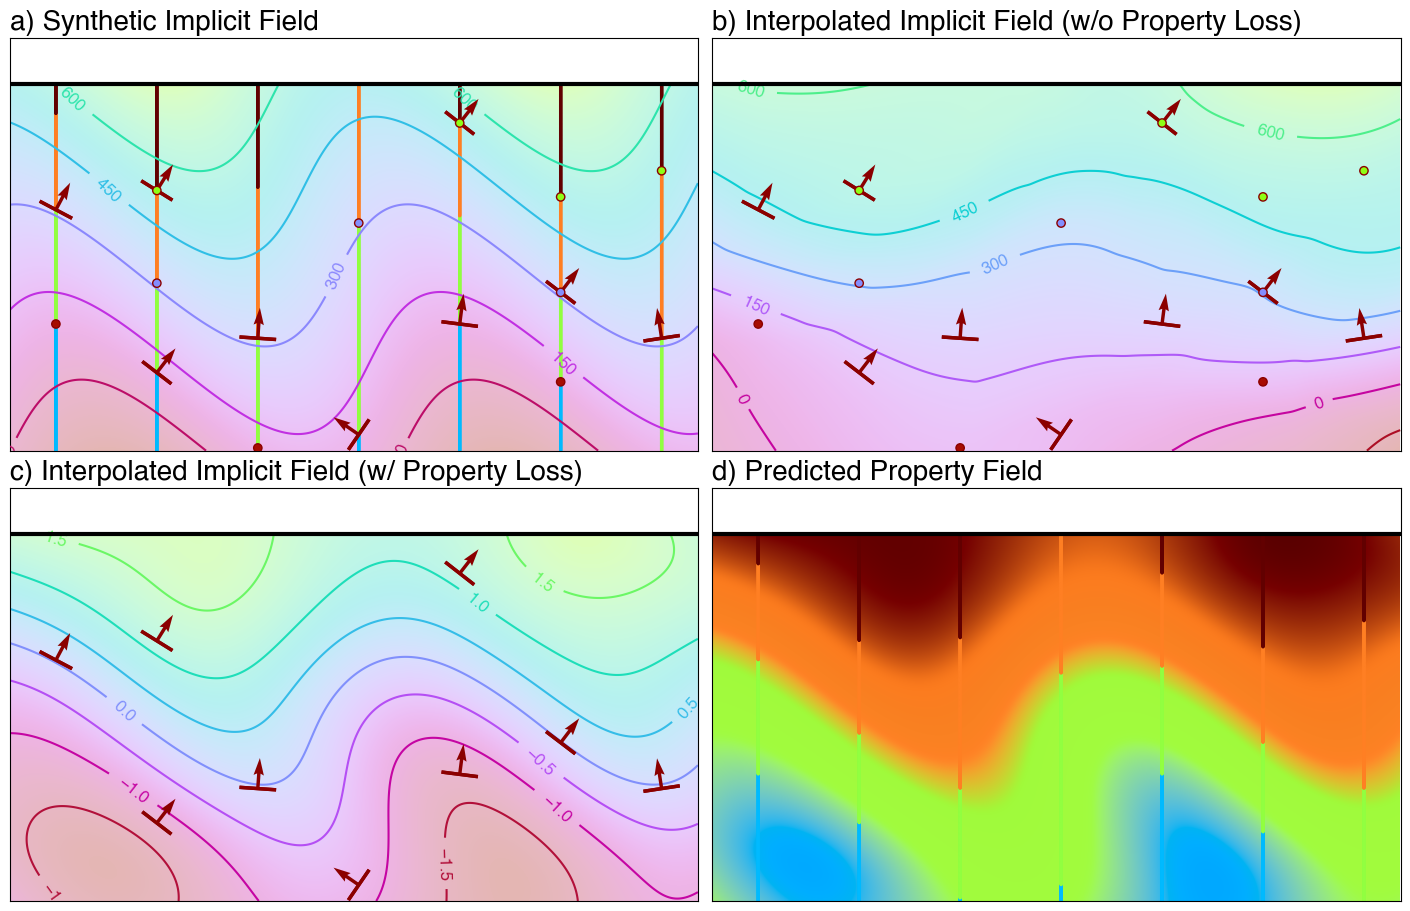

In [ ]:
# Plot the model!
fig,ax = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=True, layout="compressed")

# Define colormap
sfield_cm = cmr.neon

# Plot the original implicit field and the constraints
plot2D(original_field[:, 0], grid_obj, ax=ax.ravel()[0], cmap=sfield_cm)
plotConstraints(ax.ravel()[0], C[0], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkred"], vmn=None, cmap=sfield_cm)
plotConstraints(ax.ravel()[0], C[1])

# Plot the predicted field without property constraints
plot2D(pred_wo_prop[:, 0], grid_obj, ax=ax.ravel()[1], cmap=sfield_cm)
plotConstraints(ax.ravel()[1], C[0], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkred"], vmn=None, cmap=sfield_cm)

# Plot it with property constraints
plot2D(pred[:, 0], grid_obj, ax=ax.ravel()[2], cmap=sfield_cm)
# Since we didn't use them here :-)
C[0].vv = None
C[0].vp = None
plotConstraints(ax.ravel()[2], C[0], ll=1.2, lw=0.005, scale=0.015, ac=mcolors.CSS4_COLORS["darkred"], vmn=None, cmap=sfield_cm)

# Plot the predicted property field
plot2D(np.clip(ppred_rgb/255,0,1), grid_obj, ax=ax.ravel()[3], alpha=1, levels=False)
plotConstraints(ax.ravel()[3], C[1])

# Set titles
ax.ravel()[0].set_title("a) Synthetic Implicit Field", loc="left")
ax.ravel()[1].set_title("b) Interpolated Implicit Field (w/o Property Loss)", loc="left")
ax.ravel()[2].set_title("c) Interpolated Implicit Field (w/ Property Loss)", loc="left")
ax.ravel()[3].set_title("d) Predicted Property Field", loc="left")
    
# The lines for the surface
ax.ravel()[0].axhline(800, c="k", lw=3, zorder=9)
ax.ravel()[1].axhline(800, c="k", lw=3, zorder=9)
ax.ravel()[2].axhline(800, c="k", lw=3, zorder=9)
ax.ravel()[3].axhline(800, c="k", lw=3, zorder=9)

# Make the plot prettier
_ = [ax_.set_xticks([]) for ax_ in ax.ravel()]
_ = [ax_.set_aspect("equal") for ax_ in ax.ravel()]
ax.ravel()[0].set_ylim([0, dims[1]+100])
ax.ravel()[0].set_xlim([0, dims[0]])
_ = [ax_.set_yticks([]) for ax_ in ax.ravel()]

# Save the figure!
plt.savefig("./Figures/Interpolated_Property_Loss.png", dpi=300)
plt.show()